# Introduction to PyTorch

In this assignment, we will use PyTorch, one of the most popular deep learning libraries out there. Similarly to programming languages, deep learning libraries can be very different in terms of syntax, yet they all revolve around the same concepts, so once you master one, learning another is much less challenging. We also use `seaborn` to plot charts and `scikit-learn` to download datasets. The three cells below should install, respectively:
1. PyTorch: `torch` and `torchvision`, version at least `1.13` (2022/23 remark: version 1.13 is the most recent stable version and we use one freshly added feature)
2. Seaborn
3. `scikit-learn` version at least `0.23`.

In [1]:
!pip install 'torch>=1.13' torchvision cudatoolkit=10.0 --extra-index-url https://download.pytorch.org/whl/cpu

Defaulting to user installation because normal site-packages is not writeable
ERROR: Invalid requirement: 'cudatoolkit=10.0'
Hint: = is not a valid operator. Did you mean == ?


In [2]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install 'scikit-learn>=0.23.0'

Defaulting to user installation because normal site-packages is not writeable


# Linear regression

## Data preparation

For this task we'll consider the problem of predicting houses prices in California. We begin by loading the dataset using `fetch_california_housing`. The returned object contains a few fields:

* `data` - the matrix of features
* `feature_names` - names of the features
* `target` - the values to predict

In [4]:
from sklearn.datasets import fetch_california_housing
dataset = fetch_california_housing()

Let's see its description:

In [5]:
print(dataset.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

Now we convert the data to `torch.Tensor`, a PyTorch-specific representation of a tensor (a tensor is a generalization of a matrix to more than 2 dimensions). The `dtype` parameter forces conversion to floating-point numbers. The output of the cell is the size of the matrices. The output of the cell are the shapes of both tensors - `X` is 20640 rows by 8 columns and `y` is a vector of 20640 values

In [6]:
import torch

X = torch.tensor(dataset['data'], dtype=torch.float)
y = torch.tensor(dataset['target'], dtype=torch.float)

X.shape, y.shape

(torch.Size([20640, 8]), torch.Size([20640]))

We then split the data randomly into three subsets: a training set consisting of 70\% of the learning examples, a validation set consisting of 10\% and a test set consisting of the remaining 20\%.

In [7]:
import torch.utils.data as data
training, validation, test = data.random_split(data.TensorDataset(X, y), [0.7, 0.1, 0.2], generator=torch.Generator().manual_seed(42))

print("Training:", len(training))
print("Validation:", len(validation))
print("Test:", len(test))

Training: 14448
Validation: 2064
Test: 4128


Let's inspect the first element of the training set - it is a pair of tensors, the first one consisting of 8 values (the features), whereas the second one is a tensor of a single value (the target)

In [8]:
training[0]

(tensor([ 5.6063e+00,  1.6000e+01,  6.4174e+00,  9.6957e-01,  1.5250e+03,
          3.3152e+00,  3.7450e+01, -1.2190e+02]),
 tensor(3.2050))

## Building a simple regressor

PyTorch is based on modules (objects of the class `torch.nn.Module`), which are composed into a compution graph. Each module may use parameters (objects of the class `torch.nn.Parameter`), and for each such an object it is possible to automatically compute gradients and optimize them according to some cost function.

We begin by constructing a single linear layer, that is, a layer implementing the operation $\hat{y} = Xw + b$

In [9]:
import torch.nn as nn

regressor = nn.Linear(8, 1) # 8 input features, 1 output feature

To evaluate the performance we use mean-squared error. While PyTorch offers a ready to use implementation as the class `torch.nn.MSELoss()`, this time we implement it manually as an example. The main point is to inherit from the class `torch.nn.Module` and then to override the method `forward`, which is responsible for performing computations in the forward direction of the computation graph. Computations in the backward direction (that is, gradient flow) are derrived automatically.

In [10]:
class MSE(nn.Module):
    def __init__(self):
        super(MSE, self).__init__()
        
    def forward(self, prediction, target):
        return ((prediction-target)**2).mean()

mse = MSE()

We would like to optimize the vector `w` and `b` automatically during the learning. To this end, we use the class `torch.optim.Adam`, which implements some extensions of the graident descent algorithm. We construct the object `opt`, which is responsible for optimizing the regressor's parameters, obtained by calling `regressor.parameters()`.

In [11]:
import torch.optim as optim

opt = optim.Adam(regressor.parameters())

## Starting computations

We implement mini-batch learning over `n_epoch` epochs. Within each epoch:
1. We shuffle the training set and iterate over it in the batches of `batch_size` examples
3. We zero the gradients stored by the optimizer (`opt.zero_grad()`)
4. We execute the regressor and compute the mean-squared error (MSE).
5. We compute the gradients (`mse_value.backward()`) and apply them (`opt.step()`) to update the parameters of the regressor
6. We store the value of MSE. We call the `detach()` method to detach the MSE from its gradients. This enables passing the values to other libraries like `seaborn`.

After an epoch is completed, we average the collected MSEs and store the value.

In [12]:
import numpy as np

mse_values = []
batch_size = 100
n_epoch = 10
for epoch in range(n_epoch):    
    mse_epoch = []
    for X_batch, y_batch in data.DataLoader(training, batch_size=batch_size, shuffle=True):        
        opt.zero_grad()
        y_pred = regressor(X_batch).reshape((-1,))
        mse_value = mse(y_pred, y_batch)
        mse_value.backward()
        opt.step()
        mse_epoch.append(mse_value.item())
    mse_values.append(np.mean(mse_epoch))    

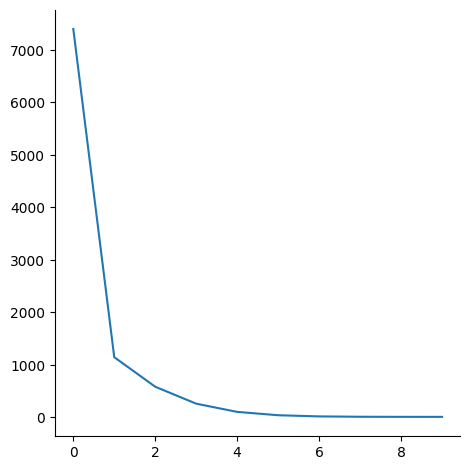

In [13]:
import seaborn as sns

_ = sns.relplot(x=range(len(mse_values)), y=mse_values, kind="line")

Execute the two preceeding cells of the code again. Because the regressor and the optimizer were not created anew, so the parameters are already optimized and the obtained charts are vastly different. In order to return to the initial state it is necessary to create new obiect `regressor` and `opt`.

## Task 1: Early stopping

Complete the function `train_linear_regression` implementing the early stopping: after each epoch of learning compute the value of MSE using the sets `X_validation` and `y_validation`. Keep track of the epoch number you got the best value of the MSE on the validation set so far. Stop the learning process if that epoch is at least `no_improvment` epochs in the past. Store MSE for validation in the `validation_mses` list and return it along with the trained regressor.

Hints and remarks:
* Observe that we must call the methods `regressor.train()` and `regressor.eval()` to switch the module between the training mode and the evaluation mode. 
* Remeber not to call `opt.step()` after performing the computation on the validation set, to not update the weights of the model. Similarly, you don't need to compute gradients during this step.
* You don't need to shuffle the validation set, nor go over it using batches. Instead, you can access the underlying tensors: `validation[:][0]` gets you the X matrix, whereas `validation[:][1]` returns the y vector.
* You may want to print out the epoch number and the value of the MSE on the validation set every time you find a better value. In the beginning you should expect a better value more or less every epoch and the decrease in MSE will be step, with time the decreases will diminishi and you'll hit a better value only every few epochs

In [14]:
def train_linear_regression(training: data.Dataset, 
                      validation: data.Dataset, 
                      n_features: int = 8, 
                      no_improvement: int = 10,
                      batch_size: int = 128,
                      max_epochs: int = 100_000):
    n_features = training[0][0].shape[0]
    regressor = nn.Linear(n_features, 1) # n_features input features, 1 output feature
    opt = optim.Adam(regressor.parameters())

    training_mses = []
    validation_mses = []
    cur_no_improvement = 0
    lowest_mse = float('inf')
    for epoch in range(max_epochs):
        regressor.train()
        for X_batch, y_batch in data.DataLoader(training, batch_size=batch_size, shuffle=True):
            opt.zero_grad()
            y_pred = regressor(X_batch).reshape((-1,))
            mse_value = mse(y_pred, y_batch)
            mse_value.backward()
            opt.step()
            training_mses.append(mse_value.item())
        regressor.eval()
        X_val = validation[:][0]
        y_val = validation[:][1]
        val_pred = regressor(X_val).reshape((-1,))
        val_mse = mse(val_pred, y_val).item()
        validation_mses.append(val_mse)
        if val_mse >= lowest_mse:
            cur_no_improvement += 1
        if val_mse < lowest_mse:
            lowest_mse = val_mse
            cur_no_improvement = 0
            print(f"Epoch: {epoch}; value of mse on validation set: {validation_mses[-1]}")
        if cur_no_improvement >= no_improvement:
            break
    return regressor, validation_mses

Let's test your solution. First, we train the regressor.

In [15]:
regressor, validation_mses = train_linear_regression(training, validation)

Epoch: 0; value of mse on validation set: 217206.796875
Epoch: 1; value of mse on validation set: 94583.046875
Epoch: 2; value of mse on validation set: 34392.40625
Epoch: 3; value of mse on validation set: 11142.24609375
Epoch: 4; value of mse on validation set: 3526.9111328125
Epoch: 5; value of mse on validation set: 1334.5302734375
Epoch: 6; value of mse on validation set: 821.4889526367188
Epoch: 7; value of mse on validation set: 672.3389892578125
Epoch: 8; value of mse on validation set: 592.23828125
Epoch: 9; value of mse on validation set: 526.5598754882812
Epoch: 10; value of mse on validation set: 465.0263366699219
Epoch: 11; value of mse on validation set: 405.9297790527344
Epoch: 12; value of mse on validation set: 351.3498229980469
Epoch: 13; value of mse on validation set: 301.2932434082031
Epoch: 14; value of mse on validation set: 255.4344482421875
Epoch: 15; value of mse on validation set: 215.4513702392578
Epoch: 16; value of mse on validation set: 178.82675170898438

We plot the last 40 values of MSE on the validation set. If you implemented the early stopping correctly, the lowest value should be exactly at 30 (`=40-no_imporvement`)

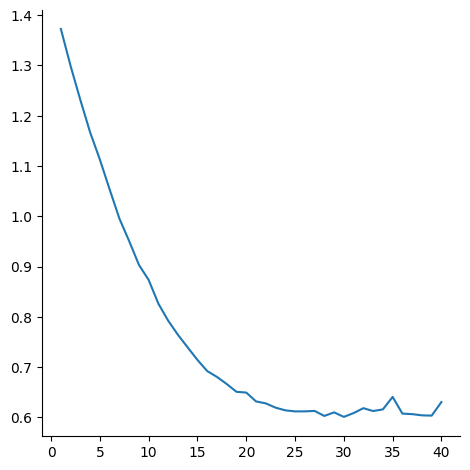

In [16]:
_ = sns.relplot(x=range(1, 41), y=validation_mses[-40:], kind="line")

Finally, let's compute the mse on the test set. It should be similar to those we got on the validation set.

In [17]:
regressor.eval()
y_pred = regressor(test[:][0]).reshape((-1,))
print("MSE on the test set:", mse(y_pred, test[:][1]).item())

MSE on the test set: 0.6399297118186951


# Classification

The second part is concerned with the classification task. We begin by downloading the MNIST dataset, consisting of 70.000 examples of handwritten digits (0-9), represented as grayscale images of 28x28 pixels. We use the function `fetch_openml` that downloads the data from [https://www.openml.org/](https://www.openml.org).

In [18]:
from sklearn.datasets import fetch_openml
mnist_sklearn = fetch_openml('mnist_784', version=1, as_frame=False)

Let's learn something about the dataset

In [19]:
print(mnist_sklearn.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [20]:
X = torch.tensor(mnist_sklearn.data, dtype=torch.float)
y = torch.tensor([int(v) for v in mnist_sklearn.target])
mnist = data.TensorDataset(X, y)
conv_mnist = data.TensorDataset(X.reshape(-1, 1, 28, 28), y)

Lets inspect some examples. The digit in the top-right corner of each image is not a part of the image itself, but rather the label of the image, displayed using `ax.text` in the code below. For the visualisation we use `matplotlib`, a library underlying the `seaborn` library.

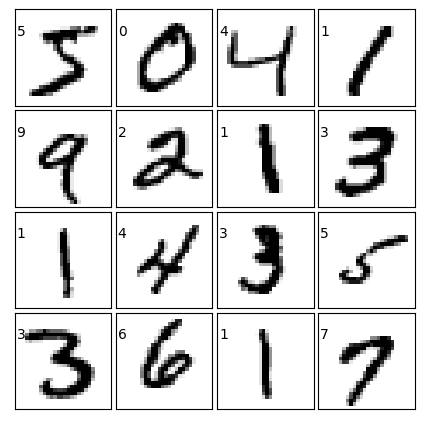

In [21]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (4,4))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(16):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    ax.imshow(mnist[i][0].reshape(28, 28),cmap=plt.cm.binary,interpolation='nearest')
    ax.text(0, 7, str(mnist[i][1].item()))

We again split the dataset into three subsets.

In [22]:
training, validation, test = data.random_split(mnist, [0.7, 0.1, 0.2], generator=torch.Generator().manual_seed(42))
conv_training, conv_validation, conv_test = data.random_split(conv_mnist, [0.7, 0.1, 0.2], generator=torch.Generator().manual_seed(42))

print("Training:", len(training))
print("Validation:", len(validation))
print("Test:", len(test))

Training: 49000
Validation: 7000
Test: 14000


## Logistic regression

We create a simple logisitc regression model, learning on the raw pixels of the images. The matrix of the feature weights (here: pixels) is of the size $p \times k$, i.e., $p$ weights for each of the $k$ classes. The model computes logits, i.e., the output of the logistic  regression **before** applying the softmax function. In the output, each row corresponds to a single example and each column to a single class. Should each row be normalized using the softmax function, each row would be a probability distribution.

In [23]:
p = 28*28
k = 10
model = nn.Linear(p, k)

As the loss function we will use *cross entropy* and perform the optimization using the Adam optimizer. Observe that the optimizer gets the set of parameters to optimize. If you create a new model, you could reuse the old `loss_function`, but the optimizer must be created anew.

In [24]:
loss_function = torch.nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters())

We create an auxiliary function to compute the classification accuracy. For each row of the `logits` matrix we select the number of the column with the highest value and compare it with the expected (true) value. This way we obtain a vector of 0s and 1s, which are then averaged to compute the accuracy.

In [25]:
def compute_acc(logits, expected):
    pred = logits.argmax(dim=1)
    return (pred == expected).type(torch.float).mean()

The remainder is very similar to the linear regression: we create a data loder (`torch.utils.data.DataLoader`)  to handle shuffling and creating batches for us, and then during each of the `n_epoch` epochs, we enable the training mode (`model.train()`), and then iterate over the loader, computing loss and gradients. Then we evaluate by computing the accuracy on the validation set.

In [26]:
loss_values = []
acc_values = []
batch_size = 512
n_epoch = 10

In [27]:
loader = data.DataLoader(training, batch_size=batch_size, shuffle=True)    

for epoch in range(n_epoch):    
    model.train()    
    epoch_loss = []
    for X_batch, y_batch in loader:
        opt.zero_grad()
        logits = model(X_batch)
        loss = loss_function(logits, y_batch)
        loss.backward()
        opt.step()        
        epoch_loss.append(loss.detach())
    model.eval()
    loss_values.append(torch.tensor(epoch_loss).mean())
    logits = model(validation[:][0])
    acc = compute_acc(logits, validation[:][1]).item()
    print("Epoch:", epoch, "accuracy:", acc)
    acc_values.append(acc)

Epoch: 0 accuracy: 0.8735714554786682
Epoch: 1 accuracy: 0.8678571581840515
Epoch: 2 accuracy: 0.8804285526275635
Epoch: 3 accuracy: 0.8882856965065002
Epoch: 4 accuracy: 0.8802857398986816
Epoch: 5 accuracy: 0.8769999742507935
Epoch: 6 accuracy: 0.8881428837776184
Epoch: 7 accuracy: 0.8658571243286133
Epoch: 8 accuracy: 0.8769999742507935
Epoch: 9 accuracy: 0.8895714282989502


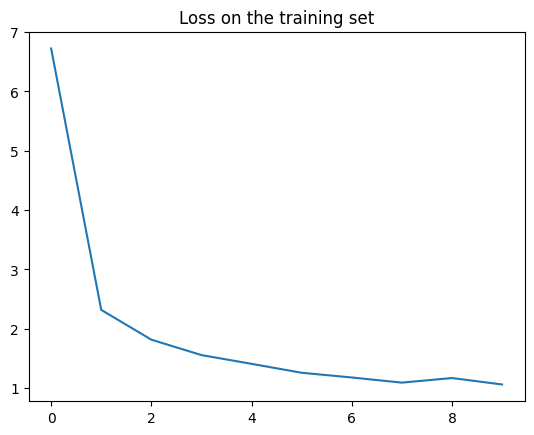

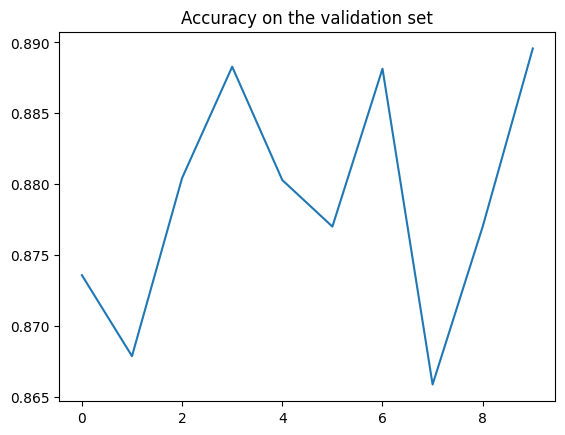

In [28]:
plt.title("Loss on the training set")
plt.plot(loss_values)
plt.show()
plt.title("Accuracy on the validation set")
plt.plot(acc_values)
plt.show()

Observe that the first epoch already gets us very high and then the improvements are very small.

## Task 2: Learning framework

The function `train_classifier` below is supposed to be an integrated tool for fitting parameters of the given `model`. Complete the function below so that it:

* Trains `model` using the training set (`training`) for at most `max_epochs` using the mini-batches of the `batch_size` size
* Implements early stopping using the validation set (`validation`), stopping if there is no improvement on accuracy for `no_improvement` epochs
* Returns a list such that i-th element of this list is the accuracy on the validation set after the i-th epoch of training
* Use the cross-entropy loss and the Adam optimizer for training, but make sure you don't reuse the global objects `loss_function` and `opt`
* Remember to switch between the training mode (`model.train()`) and the evaluation mode (`model.eval()`)

In [29]:
def train_classifier(model: nn.Module,        
              training: data.Dataset, 
              validation: data.Dataset,
              no_improvement: int = 10,
              batch_size: int = 128,
              max_epochs: int = 100_000):
    
    opt = optim.Adam(model.parameters())
    acc_values = []
    best_acc = 0
    cur_no_improvement = 0
    loader = data.DataLoader(training, batch_size=batch_size, shuffle=True)
    
    for epoch in range(max_epochs):    
        model.train()
        for X_batch, y_batch in loader:
            opt.zero_grad()
            logits = model(X_batch)
            loss = loss_function(logits, y_batch)
            loss.backward()
            opt.step()        
        model.eval()
        logits = model(validation[:][0])
        acc = compute_acc(logits, validation[:][1]).item()
        acc_values.append(acc)
        
        if best_acc >= acc:
            cur_no_improvement += 1
        if acc > best_acc:
            best_acc = acc
            cur_no_improvement = 0
            print(f"Epoch: {epoch}; accuarity on validation set: {acc}")
        if cur_no_improvement >= no_improvement:
            break
            
    return acc_values

Test it by training logistic regression on the MNIST dataset and then plotting the accuracies. The best accuracy should be on the 10-th epoch from the end.

In [30]:
model = nn.Linear(28*28, 10)
accuracies = train_classifier(model, training, validation)

Epoch: 0; accuarity on validation set: 0.8734285831451416
Epoch: 1; accuarity on validation set: 0.892714262008667
Epoch: 10; accuarity on validation set: 0.8992857336997986


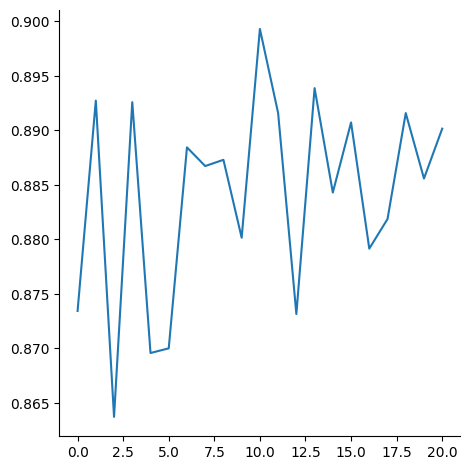

In [31]:
_ = sns.relplot(x=range(len(accuracies)), y=accuracies, kind="line")

## Task 3: A neural network with a hidden layer

Complete the cell below to create a neural network consisting of the following layers:
  1. Linear layer (`nn.Linear`) having `28*28` inputs and `300` outputs
  2. ReLU activation function (`nn.ReLU`)
  3. Dropout layer (`nn.Dropout`) with the probability of `0.5`
  4. Linear layer (`nn.Linear`) having `10` outputs
To combine layers into a single model use `nn.Sequential` 

If you haven't found it so far, the documentation for the `torch.nn` module may now be of use: [https://pytorch.org/docs/stable/nn.html](https://pytorch.org/docs/stable/nn.html)

In [32]:
model = nn.Sequential(nn.Linear(28*28, 300), nn.ReLU(), nn.Dropout(0.5), nn.Linear(300, 10))

In [33]:
accuracies = train_classifier(model, training, validation)
print("The best accurac on the validation set:", max(accuracies))

Epoch: 0; accuarity on validation set: 0.9221428632736206
Epoch: 1; accuarity on validation set: 0.9402857422828674
Epoch: 2; accuarity on validation set: 0.949571430683136
Epoch: 3; accuarity on validation set: 0.9548571705818176
Epoch: 4; accuarity on validation set: 0.9589999914169312
Epoch: 5; accuarity on validation set: 0.9617142677307129
Epoch: 6; accuarity on validation set: 0.9639999866485596
Epoch: 7; accuarity on validation set: 0.965571403503418
Epoch: 8; accuarity on validation set: 0.9661428332328796
Epoch: 9; accuarity on validation set: 0.9674285650253296
Epoch: 10; accuarity on validation set: 0.9684285521507263
Epoch: 11; accuarity on validation set: 0.9702857136726379
Epoch: 13; accuarity on validation set: 0.972428560256958
Epoch: 16; accuarity on validation set: 0.9732857346534729
Epoch: 19; accuarity on validation set: 0.9739999771118164
Epoch: 21; accuarity on validation set: 0.9755714535713196
Epoch: 22; accuarity on validation set: 0.9767143130302429
Epoch: 31;

## Task 4: Play with it!

Construct at least 6 substantially different models (use common sense - e.g., changing the number of neurons from 300 to 301 is not a substantial change). Make sure you not only consider different hyperparameters (e.g., changing the number of neurons, changing the activation function), but also different architectures (e.g., adding/removing a layer). Train them using `train_classifier` and evaluate them all on the test subset of MNIST using the accuracy measure. Print out these accuracies and indicate which model is the best.

If you want and can you can use other types of layers (e.g., convolutional layers), but please stick to what's available in PyTorch. The current state of the art on the MNIST dataset is around 99.9% accuracy [https://paperswithcode.com/sota/image-classification-on-mnist](https://paperswithcode.com/sota/image-classification-on-mnist).

In [34]:
model1 = nn.Sequential(nn.Linear(28*28, 30), nn.Dropout(0.1), nn.Dropout(0.5), nn.Dropout(.9), nn.Softmax(1))
accuracies = train_classifier(model1, training, validation)
print("The best accurac on the validation set:", max(accuracies))

Epoch: 0; accuarity on validation set: 0.21057142317295074
Epoch: 4; accuarity on validation set: 0.21214285492897034
Epoch: 12; accuarity on validation set: 0.21785713732242584
Epoch: 13; accuarity on validation set: 0.21957142651081085
Epoch: 15; accuarity on validation set: 0.22514285147190094
Epoch: 16; accuarity on validation set: 0.22542856633663177
Epoch: 17; accuarity on validation set: 0.2305714339017868
Epoch: 18; accuarity on validation set: 0.23242856562137604
Epoch: 26; accuarity on validation set: 0.23499999940395355
Epoch: 27; accuarity on validation set: 0.23514285683631897
Epoch: 29; accuarity on validation set: 0.2354285717010498
The best accurac on the validation set: 0.2354285717010498


In [35]:
model2 = nn.Sequential(nn.Linear(28*28, 150), nn.LeakyReLU(), nn.Dropout(.9), nn.Softmax(1), nn.Linear(150, 10))
accuracies = train_classifier(model2, training, validation)
print("The best accurac on the validation set:", max(accuracies))

Epoch: 0; accuarity on validation set: 0.13171428442001343
Epoch: 1; accuarity on validation set: 0.14085714519023895
Epoch: 2; accuarity on validation set: 0.3602857291698456
Epoch: 4; accuarity on validation set: 0.3701428472995758
Epoch: 5; accuarity on validation set: 0.3779999911785126
Epoch: 6; accuarity on validation set: 0.3831428587436676
Epoch: 7; accuarity on validation set: 0.4845714271068573
Epoch: 8; accuarity on validation set: 0.5127142667770386
The best accurac on the validation set: 0.5127142667770386


In [36]:
model3 = nn.Sequential(nn.Linear(28*28, 150), nn.Dropout(0.1), nn.LogSigmoid(), nn.Dropout(.4), nn.Softmax(1), nn.Linear(150, 10))
accuracies = train_classifier(model3, training, validation)
print("The best accurac on the validation set:", max(accuracies))

Epoch: 0; accuarity on validation set: 0.6472856998443604
Epoch: 1; accuarity on validation set: 0.7675714492797852
Epoch: 2; accuarity on validation set: 0.8335714340209961
Epoch: 3; accuarity on validation set: 0.8565714359283447
Epoch: 4; accuarity on validation set: 0.8691428303718567
Epoch: 5; accuarity on validation set: 0.8761428594589233
Epoch: 6; accuarity on validation set: 0.8792856931686401
Epoch: 7; accuarity on validation set: 0.8799999952316284
Epoch: 8; accuarity on validation set: 0.8815714120864868
Epoch: 9; accuarity on validation set: 0.8838571310043335
Epoch: 10; accuarity on validation set: 0.8911428451538086
Epoch: 15; accuarity on validation set: 0.8922857046127319
Epoch: 16; accuarity on validation set: 0.8924285769462585
Epoch: 17; accuarity on validation set: 0.8932856917381287
Epoch: 18; accuarity on validation set: 0.8935714364051819
Epoch: 19; accuarity on validation set: 0.8962857127189636
Epoch: 26; accuarity on validation set: 0.8975714445114136
Epoch: 

In [37]:
model4 = nn.Sequential(nn.Linear(28*28, 150), nn.Softmax(1), nn.Linear(150, 10))
accuracies = train_classifier(model4, training, validation)
print("The best accurac on the validation set:", max(accuracies))

Epoch: 0; accuarity on validation set: 0.5484285950660706
Epoch: 1; accuarity on validation set: 0.5851428508758545
Epoch: 3; accuarity on validation set: 0.5882856845855713
Epoch: 5; accuarity on validation set: 0.5971428751945496
Epoch: 9; accuarity on validation set: 0.6132857203483582
Epoch: 12; accuarity on validation set: 0.6144285798072815
Epoch: 14; accuarity on validation set: 0.6204285621643066
Epoch: 15; accuarity on validation set: 0.6205714344978333
Epoch: 25; accuarity on validation set: 0.6248571276664734
Epoch: 27; accuarity on validation set: 0.6282857060432434
Epoch: 32; accuarity on validation set: 0.6304285526275635
Epoch: 38; accuarity on validation set: 0.6311428546905518
Epoch: 43; accuarity on validation set: 0.6331428289413452
Epoch: 45; accuarity on validation set: 0.6359999775886536
Epoch: 48; accuarity on validation set: 0.6368571519851685
Epoch: 49; accuarity on validation set: 0.6371428370475769
Epoch: 50; accuarity on validation set: 0.6381428837776184
Ep

In [38]:
model5 = nn.Sequential(nn.Linear(28*28, 400), nn.MaxPool1d(5), nn.LeakyReLU(), nn.Softmax(1), nn.Linear(80, 10))
accuracies = train_classifier(model5, training, validation, no_improvement=10)
print("The best accurac on the validation set:", max(accuracies))

Epoch: 0; accuarity on validation set: 0.6432856917381287
Epoch: 1; accuarity on validation set: 0.7044285535812378
Epoch: 2; accuarity on validation set: 0.7558571696281433
Epoch: 3; accuarity on validation set: 0.7581428289413452
Epoch: 4; accuarity on validation set: 0.7868571281433105
Epoch: 5; accuarity on validation set: 0.7998571395874023
Epoch: 6; accuarity on validation set: 0.8395714163780212
Epoch: 7; accuarity on validation set: 0.8444285988807678
Epoch: 8; accuarity on validation set: 0.8707143068313599
Epoch: 9; accuarity on validation set: 0.8824285864830017
Epoch: 10; accuarity on validation set: 0.8952857255935669
Epoch: 11; accuarity on validation set: 0.9044285416603088
Epoch: 13; accuarity on validation set: 0.9072856903076172
Epoch: 17; accuarity on validation set: 0.9148571491241455
Epoch: 26; accuarity on validation set: 0.9152857065200806
Epoch: 27; accuarity on validation set: 0.9204285740852356
The best accurac on the validation set: 0.9204285740852356


In [39]:
model6 = nn.Sequential(nn.Linear(28*28, 200), nn.MaxPool1d(5), nn.ReLU(), nn.LogSoftmax(1), nn.Linear(40, 10))
accuracies = train_classifier(model6, training, validation, no_improvement=10)
print("The best accurac on the validation set:", max(accuracies))

Epoch: 0; accuarity on validation set: 0.9241428375244141
Epoch: 1; accuarity on validation set: 0.943142831325531
Epoch: 2; accuarity on validation set: 0.951714277267456
Epoch: 3; accuarity on validation set: 0.9549999833106995
Epoch: 5; accuarity on validation set: 0.959857165813446
Epoch: 6; accuarity on validation set: 0.9624285697937012
Epoch: 7; accuarity on validation set: 0.9631428718566895
Epoch: 9; accuarity on validation set: 0.9641428589820862
Epoch: 10; accuarity on validation set: 0.9662857055664062
Epoch: 13; accuarity on validation set: 0.9687142968177795
Epoch: 17; accuarity on validation set: 0.970714271068573
Epoch: 20; accuarity on validation set: 0.9710000157356262
Epoch: 21; accuarity on validation set: 0.9725714325904846
Epoch: 30; accuarity on validation set: 0.9729999899864197
The best accurac on the validation set: 0.9729999899864197


In [40]:
model7 = nn.Sequential(nn.Linear(28*28, 500), nn.MaxPool1d(10), nn.LogSigmoid(), nn.Dropout(.5), nn.Linear(50, 10), nn.LogSoftmax(1))
accuracies = train_classifier(model7, training, validation, no_improvement=10)
print("The best accurac on the validation set:", max(accuracies))

Epoch: 0; accuarity on validation set: 0.730571448802948
Epoch: 1; accuarity on validation set: 0.8214285969734192
Epoch: 2; accuarity on validation set: 0.881428599357605
Epoch: 3; accuarity on validation set: 0.8942857384681702
Epoch: 4; accuarity on validation set: 0.9070000052452087
Epoch: 5; accuarity on validation set: 0.9120000004768372
Epoch: 6; accuarity on validation set: 0.9192857146263123
Epoch: 7; accuarity on validation set: 0.9194285869598389
Epoch: 8; accuarity on validation set: 0.9269999861717224
Epoch: 10; accuarity on validation set: 0.9337142705917358
Epoch: 14; accuarity on validation set: 0.9365714192390442
Epoch: 15; accuarity on validation set: 0.9368571639060974
Epoch: 17; accuarity on validation set: 0.9381428360939026
Epoch: 19; accuarity on validation set: 0.9424285888671875
Epoch: 20; accuarity on validation set: 0.9428571462631226
Epoch: 23; accuarity on validation set: 0.9452857375144958
Epoch: 24; accuarity on validation set: 0.9480000138282776
Epoch: 2

In [ ]:
model8 = nn.Sequential(nn.Linear(28*28, 500),
                       nn.LogSigmoid(),
                       nn.Linear(500, 250),
                       nn.LogSigmoid(),
                       nn.Dropout(0.5),
                       nn.Linear(250, 100),
                       nn.LogSigmoid(),
                       nn.Linear(100, 50),
                       nn.LogSigmoid(),
                       nn.Dropout(0.5),
                       nn.Linear(50, 10),
                       nn.LogSoftmax(1))
accuracies = train_classifier(model8, training, validation, no_improvement=10)
print("The best accurac on the validation set:", max(accuracies))

Epoch: 0; accuarity on validation set: 0.9527142643928528
Epoch: 1; accuarity on validation set: 0.9647142887115479
Epoch: 2; accuarity on validation set: 0.972428560256958
Epoch: 5; accuarity on validation set: 0.9761428833007812
Epoch: 9; accuarity on validation set: 0.9774285554885864
Epoch: 13; accuarity on validation set: 0.9782857298851013
Epoch: 14; accuarity on validation set: 0.9785714149475098
Epoch: 18; accuarity on validation set: 0.9801428318023682
Epoch: 19; accuarity on validation set: 0.9804285764694214
Epoch: 27; accuarity on validation set: 0.9810000061988831
Epoch: 28; accuarity on validation set: 0.9841428399085999


Looking at my models, I think that the last one is definately the best, learns fastest and has decent accuarity. To be honest in the begging I have no idea want am doing but later I figured out couple things and even tried convolutional layers, but my computer wasn't so kind to allow me to unleash their potential.

----
Some final remarks:
* PyTorch also offers autoloading some datasets, see e.g. [https://pytorch.org/vision/stable/datasets.html](https://pytorch.org/vision/stable/datasets.html)
* Early stopping should also save the parameters of the best model and restore them upon termination. I decided to skip this part to avoid adding yet another opaque piece. If you are interested see [https://pytorch.org/tutorials/beginner/basics/saveloadrun_tutorial.html](https://pytorch.org/tutorials/beginner/basics/saveloadrun_tutorial.html)
* As all deep learning libraries, PyTorch offers support for offloading computation to GPU. In practice the difference is tremendous, but you need a graphics card supporting CUDA, i.e., an Nvidia card. Since this is a rather restrictive requirement, I elected not to introduce this aspect. If you are interested, see e.g. [https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html). If you don't have an Nvidia card, there are services out there that will allow you to access one for free for a short period of time, e.g., Google Colab [https://colab.research.google.com/](https://colab.research.google.com/) or Paperspace Gradient [https://www.paperspace.com/gradient/free-gpu](https://www.paperspace.com/gradient/free-gpu).
* *Layer* is a vague term. It could be argued that neither dropout nor relu by themselves are layers, but rather they form a single layer together with `nn.Linear`. In here, I elected to follow the same naming convention that is used in the PyTorch documentation.